# Comparativo de Modelos para Detecção de Emoções (Fluxo Direto com Data Augmentation)

Este notebook implementa o fluxo completo para treinar e comparar dois modelos de deep learning para classificação de emoções faciais e a técnica de **Data Augmentation**.

1.  **Importação e Configuração:** Carrega as bibliotecas e define as constantes do projeto.
2.  **Carregamento e Pré-processamento:** Carrega os dados do arquivo `fer2013.csv` e os prepara para as duas arquiteturas.
3.  **Data Augmentation:** Configura um gerador de imagens para criar variações dos dados de treino, aumentando a robustez dos modelos.
4.  **Modelo 1 - CNN Personalizada:** Construção e treinamento da CNN utilizando os dados aumentados.
5.  **Modelo 2 - Transfer Learning:** Uso do modelo VGG16, também treinado com os dados aumentados.
6.  **Comparação:** Avaliação de ambos os modelos e visualização de suas matrizes de confusão.

In [1]:
#Importação das bibliotecas necessárias e carregando as variáveis necessárias ao longo do código.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Conv2D, 
                                     MaxPooling2D, BatchNormalization, Input, 
                                     GlobalAveragePooling2D)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

classes = ["Raiva", "Nojo", "Medo", "Feliz", "Triste", "Surpreso", "Neutro"] # As classes das expressoes em ordem
epochs = 100  
batch_size = 32
caminho_arquivo = 'Material/fer2013/fer2013.csv'

2025-09-09 16:29:16.962523: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-09 16:29:17.002052: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-09 16:29:17.906013: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
#Configuração da GPU para podermos treinar com mais facilidade os modelos

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

I0000 00:00:1757446158.289554   40567 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4147 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


1 Physical GPUs, 1 Logical GPUs


In [3]:
#Carregamento da base de dados, e pre processamento deles

data = pd.read_csv(caminho_arquivo)

pixels = data['pixels'].tolist()
faces = []
for pixel_sequence in pixels:
    face = [int(p) for p in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(48, 48)
    faces.append(face)

#Converte para float e normaliza entre 0 e 1
faces = np.asarray(faces).astype('float32') / 255.0
    
#transforma one-hot encoding
labels = to_categorical(data['emotion'], num_classes=len(classes))
    
#Dados para a cnn personalizada
faces_gray = np.expand_dims(faces, -1)
    
#Dados para o VGG16
faces_rgb = np.stack((faces,) * 3, axis=-1)
    
print(f"Dataset pronto: {len(faces)} imagens carregadas.")
print(f"Shape para CNN (escala de cinza): {faces_gray.shape}")
print(f"Shape para Transfer Learning (RGB): {faces_rgb.shape}")

Dataset pronto: 35887 imagens carregadas.
Shape para CNN (escala de cinza): (35887, 48, 48, 1)
Shape para Transfer Learning (RGB): (35887, 48, 48, 3)


In [4]:
#Configuração do Data Augment
datagen = ImageDataGenerator(
    rotation_range=15,          #Rotaciona a imagem aleatoriamente em até 15 graus
    width_shift_range=0.1,      #Desloca a imagem horizontalmente
    height_shift_range=0.1,     #Desloca a imagem verticalmente
    shear_range=0.1,            #Aplica cisalhamento
    zoom_range=0.1,             #Aplica zoom aleatório
    horizontal_flip=True,       #Inverte a imagem horizontalmente
    fill_mode='nearest'         #Preenche pixels novos com o valor do mais próximo
)

In [5]:
#Criação da rede neural convolucional para comparar com o modelo VGG16
X_train_gray, X_test_gray, y_train_gray, y_test_gray = train_test_split(
    faces_gray, labels, test_size=0.2, random_state=42, stratify=labels
)

model_custom_cnn = Sequential([
    #Primeira camada de convolução
    Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    #Segunda camada
    Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    #Terceira
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    #Flattening e camada densa
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(len(classes), activation='softmax')
])

#Compilação com o otimizador Adam e passando as metricas de loss e acuracia
model_custom_cnn.compile(optimizer=Adam(learning_rate=0.001), 
                         loss='categorical_crossentropy', 
                         metrics=['accuracy'])

model_custom_cnn.summary()

#Treinamento do modelo
history_cnn = model_custom_cnn.fit(
    datagen.flow(X_train_gray, y_train_gray, batch_size=batch_size),
    steps_per_epoch=len(X_train_gray) // batch_size,
    epochs=epochs,
    validation_data=(X_test_gray, y_test_gray),
    verbose=2
)

/home/lucas/anaconda3/envs/tf_gpu_pip/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,094,151 (19.43 MB)

 Trainable params: 5,093,255 (19.43 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100


/home/lucas/anaconda3/envs/tf_gpu_pip/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-09-09 16:29:29.823411: I external/local_xla/xla/service/service.cc:163] XLA service 0x7067f0012710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-09 16:29:29.823430: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-09-09 16:29:29.861589: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-09 16:29:30.121005: I external/local_xla/xla/st

897/897 - 27s - 30ms/step - accuracy: 0.2486 - loss: 2.1672 - val_accuracy: 0.3107 - val_loss: 1.6956
Epoch 2/100


/home/lucas/anaconda3/envs/tf_gpu_pip/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


897/897 - 1s - 1ms/step - accuracy: 0.3750 - loss: 1.6537 - val_accuracy: 0.3075 - val_loss: 1.7039
Epoch 3/100
897/897 - 14s - 16ms/step - accuracy: 0.2990 - loss: 1.7181 - val_accuracy: 0.3625 - val_loss: 1.5775
Epoch 4/100
897/897 - 1s - 1ms/step - accuracy: 0.3750 - loss: 1.5978 - val_accuracy: 0.3624 - val_loss: 1.5700
Epoch 5/100
897/897 - 14s - 16ms/step - accuracy: 0.3349 - loss: 1.6563 - val_accuracy: 0.3816 - val_loss: 1.5818
Epoch 6/100
897/897 - 1s - 1ms/step - accuracy: 0.4062 - loss: 1.5273 - val_accuracy: 0.3823 - val_loss: 1.5834
Epoch 7/100
897/897 - 14s - 16ms/step - accuracy: 0.3521 - loss: 1.6116 - val_accuracy: 0.3866 - val_loss: 1.5213
Epoch 8/100
897/897 - 1s - 1ms/step - accuracy: 0.2500 - loss: 1.9610 - val_accuracy: 0.3918 - val_loss: 1.5106
Epoch 9/100
897/897 - 14s - 16ms/step - accuracy: 0.3682 - loss: 1.5835 - val_accuracy: 0.4675 - val_loss: 1.3932
Epoch 10/100
897/897 - 1s - 1ms/step - accuracy: 0.3438 - loss: 1.5898 - val_accuracy: 0.4678 - val_loss: 1.

In [6]:
#Modelo VGG16

#Separação dos dados de teste e treino
X_train_rgb, X_test_rgb, y_train_rgb, y_test_rgb = train_test_split(
    faces_rgb, labels, test_size=0.2, random_state=42, stratify=labels
)

#arquitetura do modelo
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
base_model_vgg.trainable = False  

#Adicionando uma camada densa no final
model_transfer = Sequential([
    base_model_vgg,
    GlobalAveragePooling2D(),
    Dense(len(classes), activation='softmax')
])

#Compilando
model_transfer.compile(optimizer=Adam(learning_rate=0.001), 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

p
model_transfer.summary()

#Treinando o modelo
history_transfer = model_transfer.fit(
    datagen.flow(X_train_rgb, y_train_rgb, batch_size=batch_size),
    steps_per_epoch=len(X_train_rgb) // batch_size,
    epochs=epochs,
    validation_data=(X_test_rgb, y_test_rgb),
    verbose=2
)

Arquitetura do Modelo de Transferência:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,718,279 (56.15 MB)

 Trainable params: 3,591 (14.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


Treinando o modelo VGG16 com Data Augmentation...
Epoch 1/100


/home/lucas/anaconda3/envs/tf_gpu_pip/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-09-09 16:42:25.414853: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_633', 12 bytes spill stores, 24 bytes spill loads

2025-09-09 16:42:44.517880: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_257', 12 bytes spill stores, 24 bytes spill loads



897/897 - 26s - 29ms/step - accuracy: 0.3216 - loss: 1.6962 - val_accuracy: 0.3615 - val_loss: 1.6201
Epoch 2/100


/home/lucas/anaconda3/envs/tf_gpu_pip/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


897/897 - 4s - 5ms/step - accuracy: 0.3438 - loss: 1.7341 - val_accuracy: 0.3605 - val_loss: 1.6207
Epoch 3/100
897/897 - 20s - 23ms/step - accuracy: 0.3622 - loss: 1.6257 - val_accuracy: 0.3870 - val_loss: 1.5809
Epoch 4/100
897/897 - 4s - 5ms/step - accuracy: 0.4062 - loss: 1.5738 - val_accuracy: 0.3848 - val_loss: 1.5816
Epoch 5/100
897/897 - 20s - 23ms/step - accuracy: 0.3698 - loss: 1.6084 - val_accuracy: 0.3938 - val_loss: 1.5655
Epoch 6/100
897/897 - 4s - 5ms/step - accuracy: 0.5312 - loss: 1.3761 - val_accuracy: 0.3945 - val_loss: 1.5651
Epoch 7/100
897/897 - 20s - 23ms/step - accuracy: 0.3754 - loss: 1.5951 - val_accuracy: 0.3816 - val_loss: 1.5792
Epoch 8/100
897/897 - 4s - 5ms/step - accuracy: 0.3750 - loss: 1.5861 - val_accuracy: 0.3798 - val_loss: 1.5814
Epoch 9/100
897/897 - 20s - 23ms/step - accuracy: 0.3772 - loss: 1.5894 - val_accuracy: 0.3982 - val_loss: 1.5486
Epoch 10/100
897/897 - 4s - 5ms/step - accuracy: 0.4062 - loss: 1.4355 - val_accuracy: 0.3990 - val_loss: 1.

Mostrando exemplos de Data Augmentation em uma imagem de treino.


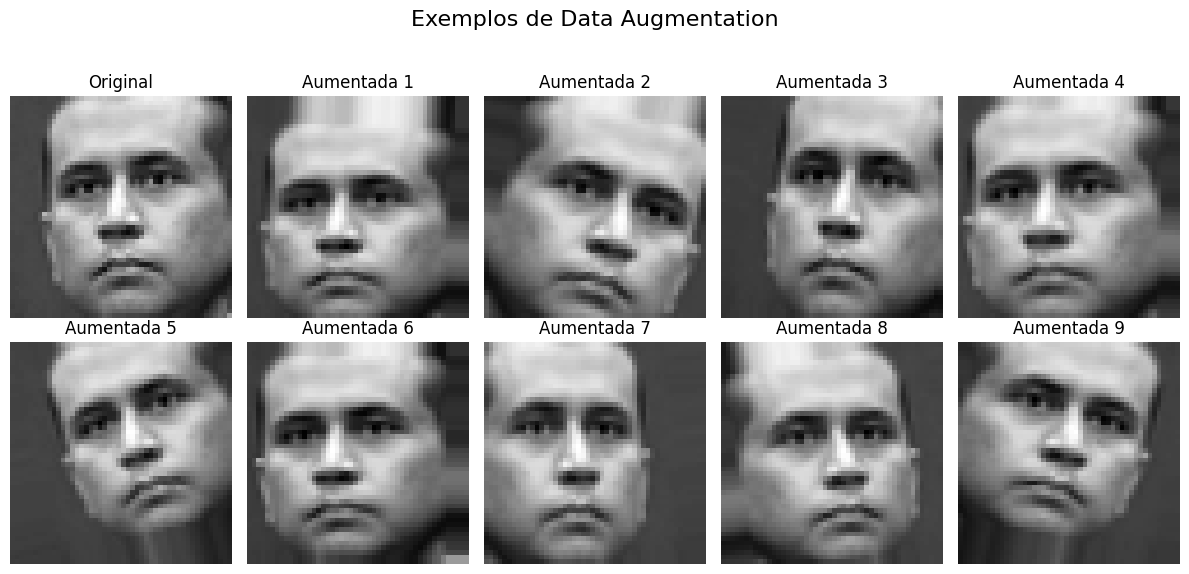

In [7]:
#Plot para visualizar os efeitos criados através do data augmentation

imagem_exemplo = X_train_gray[5] 
IMG_SIZE = 48

imagem_para_gerador = np.expand_dims(imagem_exemplo, 0)

plt.figure(figsize=(12, 6))

ax = plt.subplot(2, 5, 1)
ax.imshow(imagem_exemplo.reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
ax.set_title("Original")
ax.axis("off")

i = 1
for batch in datagen.flow(imagem_para_gerador, batch_size=1):
    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(batch[0].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    ax.set_title(f"Aumentada {i}")
    ax.axis("off")
    i += 1
    if i > 9:
        break 
plt.suptitle("Exemplos de Data Augmentation", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step


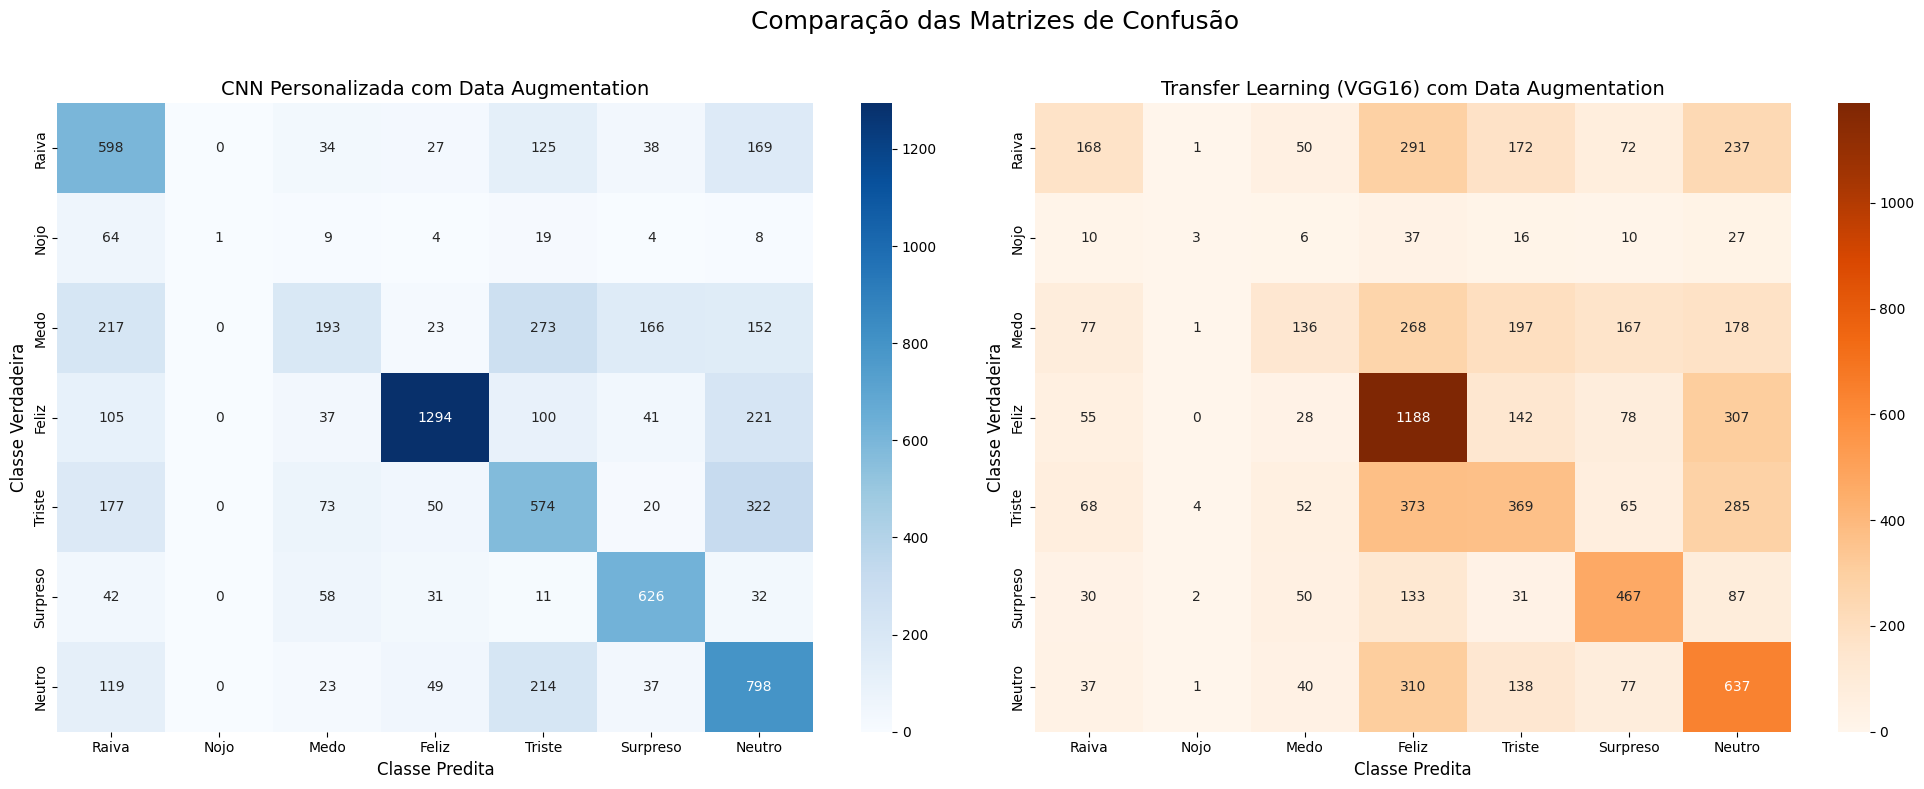

In [8]:
#Plot das matrizes de consfusão de cada modelo

y_pred_cnn = np.argmax(model_custom_cnn.predict(X_test_gray), axis=1)
y_true_labels = np.argmax(y_test_gray, axis=1) 

y_pred_transfer = np.argmax(model_transfer.predict(X_test_rgb), axis=1)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Comparação das Matrizes de Confusão', fontsize=18)

cm_cnn = confusion_matrix(y_true_labels, y_pred_cnn)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=axes[0])
axes[0].set_title('CNN Personalizada com Data Augmentation', fontsize=14)
axes[0].set_ylabel('Classe Verdadeira', fontsize=12)
axes[0].set_xlabel('Classe Predita', fontsize=12)


cm_transfer = confusion_matrix(y_true_labels, y_pred_transfer)
sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Oranges', xticklabels=classes, yticklabels=classes, ax=axes[1])
axes[1].set_title('Transfer Learning (VGG16) com Data Augmentation', fontsize=14)
axes[1].set_ylabel('Classe Verdadeira', fontsize=12)
axes[1].set_xlabel('Classe Predita', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

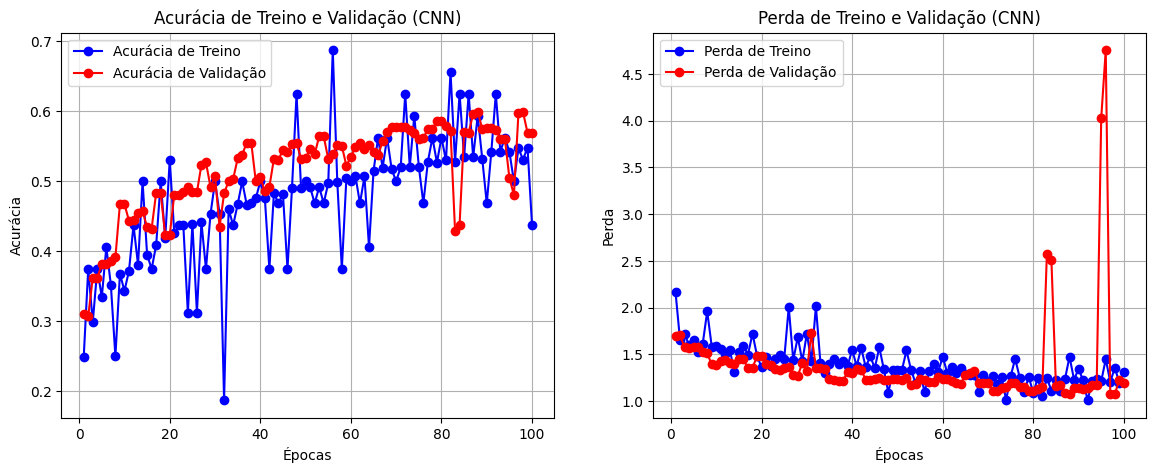

In [9]:
#Plot de como a CNN criada para mostrar como se comportou a cada época
history_dict_cnn = history_cnn.history

acc = history_dict_cnn['accuracy']
val_acc = history_dict_cnn['val_accuracy']
loss = history_dict_cnn['loss']
val_loss = history_dict_cnn['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

#Primeiro gŕafico
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, 'ro-', label='Acurácia de Validação')
plt.title('Acurácia de Treino e Validação (CNN)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

#Segundo gráfico
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Perda de Treino')
plt.plot(epochs_range, val_loss, 'ro-', label='Perda de Validação')
plt.title('Perda de Treino e Validação (CNN)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)

plt.show()

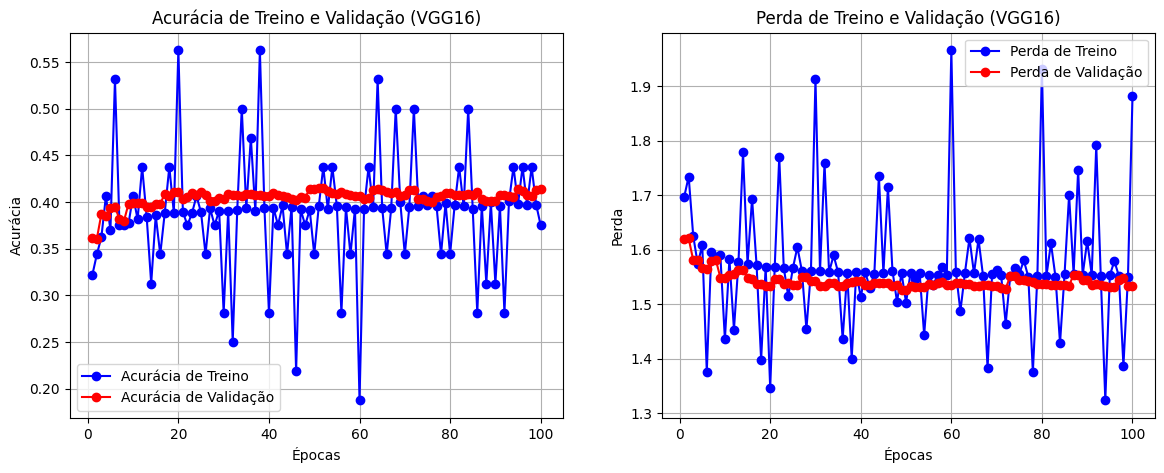

In [11]:
#Plot dos gráficos de como o VGG se comportou a cada época
history_dict_cnn = history_transfer.history

acc = history_dict_cnn['accuracy']
val_acc = history_dict_cnn['val_accuracy']
loss = history_dict_cnn['loss']
val_loss = history_dict_cnn['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

#Primeiro gráfico
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, 'ro-', label='Acurácia de Validação')
plt.title('Acurácia de Treino e Validação (VGG16)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

#Segundo gráfico
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Perda de Treino')
plt.plot(epochs_range, val_loss, 'ro-', label='Perda de Validação')
plt.title('Perda de Treino e Validação (VGG16)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)

plt.show()